# GUIDE FOR REGRESSION PROBLEMS

In this notebook I will solve a regression problem. **The goal for this notebook is to give a idea of the steps we need to follow to solve a regression problem** and to show some interesting techniques to do it.

The problem we will be solving is this:  [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)

In this notebook I put together different concepts I found in the following notebooks. Kudos to these guys for the great work:
* [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* [Simple approach to predict house price](https://www.kaggle.com/shubhammahajan3110/simple-approach-to-predict-house-price)
* [XGBoost + Lasso](https://www.kaggle.com/humananalog/xgboost-lasso)


Any comments or suggestions are very welcome.

Ok, we begin by importing a set of packages we'll be needing:

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Importing the data:

In [94]:
df_train = pd.read_csv('/home/pablo/Escritorio/Postgrado_UB/Problemas Kaggle/Plantillas/REGRESIÓN/datos/train.csv')
df_test = pd.read_csv('/home/pablo/Escritorio/Postgrado_UB/Problemas Kaggle/Plantillas/REGRESIÓN/datos/test.csv')

### STEP 0 : EXPLORE TARGET VARIABLE

First of all, let's analyze the target column 'SalePrice'

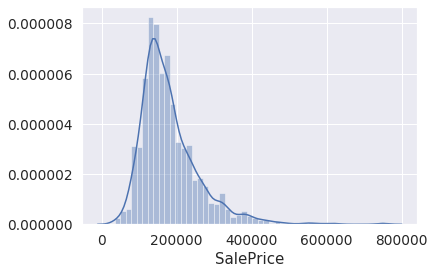

In [95]:
sns.distplot(df_train.SalePrice)

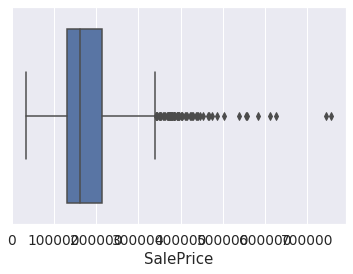

In [96]:
sns.boxplot(df_train['SalePrice'])

We can see that the distribution is skewed to the right (positive skew). Let's take a look at the [skewness and kurtosis](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa):

In [97]:
print('Skewness: ',df_train['SalePrice'].skew())
print('Kurtosis: ',df_train['SalePrice'].kurt())

Skewness:  1.8828757597682129
Kurtosis:  6.536281860064529


In order to address this problem we can apply a [Box-Cox](https://blog.minitab.com/blog/applying-statistics-in-quality-projects/how-could-you-benefit-from-a-box-cox-transformation) transformation. In this case I will use a Box-Cox with lambda= 0 wich is basically a logarithmic transformation:

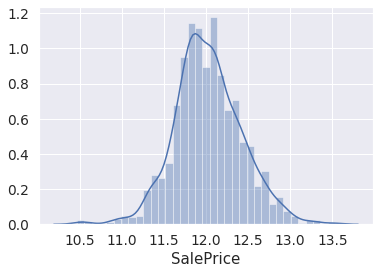

In [98]:
df_train['SalePrice']=np.log1p(df_train['SalePrice'])

sns.distplot(df_train['SalePrice'])

We find a couple of outliers when we plot SalePrice against the top 2 most correlated feature, 'GrLivArea'. Let's plot them and drop those rows

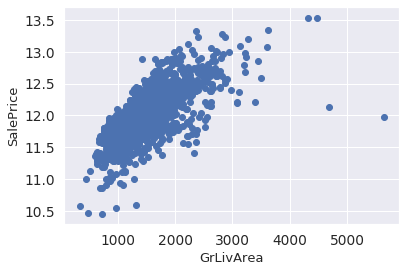

In [99]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [100]:
df_train.drop(df_train[df_train['GrLivArea']>4000].index, inplace=True)

Now that we have tranformed the target variable, we can put together train a test data

In [101]:
ntrain = df_train.shape[0] #we do this because we are going to concatenate train and test and we will need this later
ntest = df_test.shape[0] 

y_train = df_train.SalePrice.values

df_all = pd.concat((df_train, df_test)).reset_index(drop=True)
df_all.drop(['SalePrice'], axis=1, inplace=True)

df=df_all

### STEP 1 : EXPLORATORY DATA ANALYSIS (EDA)

Overview of the dataset 

In [102]:
def overview(df):
    print('SHAPE: ', df.shape)
    print('columns: ', df.columns.tolist())
    col_nan=df.columns[df.isnull().any()].tolist()
    print('columns with missing data: ',df[col_nan].isnull().sum())

overview(df)

SHAPE:  (2915, 80)
columns:  ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Screen

It looks like we have a lot of columns with missing data. Let's rank the variables with the hisghest % of missing data

In [103]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
PoolQC,99.725557
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.672384
GarageQual,5.454545
GarageCond,5.454545
GarageFinish,5.454545
GarageYrBlt,5.454545


Let's see how variables correlate with each other

In [104]:
corrmat = df_train.corr()
corrmat['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.819240
GrLivArea        0.718844
GarageCars       0.680408
GarageArea       0.655212
TotalBsmtSF      0.641553
1stFlrSF         0.613742
FullBath         0.590919
YearBuilt        0.588977
YearRemodAdd     0.568986
GarageYrBlt      0.544005
TotRmsAbvGrd     0.533446
Fireplaces       0.487126
MasVnrArea       0.430073
BsmtFinSF1       0.382710
LotFrontage      0.363286
WoodDeckSF       0.330573
OpenPorchSF      0.327038
HalfBath         0.311191
2ndFlrSF         0.306605
LotArea          0.258945
BsmtFullBath     0.238851
BsmtUnfSF        0.223248
BedroomAbvGr     0.204117
ScreenPorch      0.123860
MoSold           0.062231
3SsnPorch        0.056065
PoolArea         0.040679
BsmtFinSF2       0.006420
BsmtHalfBath    -0.014974
MiscVal         -0.019752
Id              -0.020511
YrSold          -0.034319
OverallCond     -0.036843
LowQualFinSF    -0.037698
MSSubClass      -0.075083
KitchenAbvGr    -0.147891
EnclosedPorch   -0.148636
Name: SalePr

Let's take a look at the 10 variables that are more correlated to the target

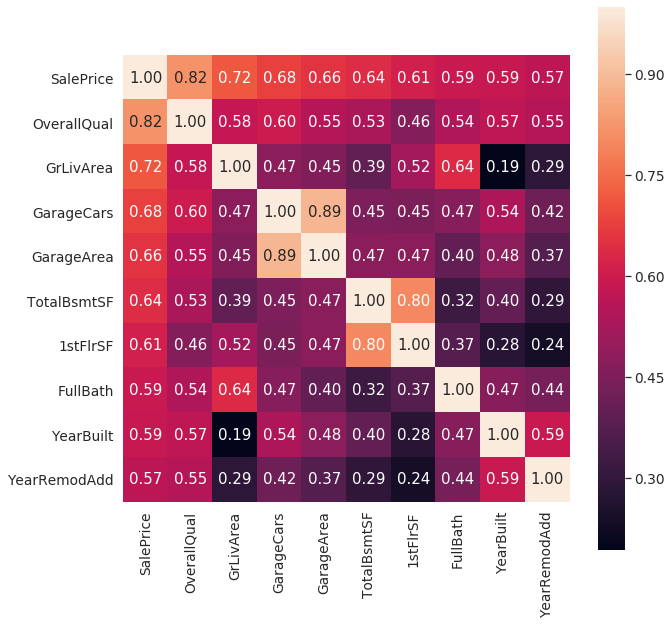

In [105]:
import matplotlib.pyplot as plt#visualization
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Let's take a look at the values of all the **categorical** variables

In [106]:
cat_cols = df.select_dtypes('object').columns.tolist()

for i in cat_cols:
    print(df[i].value_counts())

Grvl    120
Pave     78
Name: Alley, dtype: int64
1Fam      2421
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64
TA    2602
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64
No    1904
Av     417
Gd     273
Mn     239
Name: BsmtExposure, dtype: int64
Unf    851
GLQ    845
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64
Unf    2489
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64
TA    1283
Gd    1209
Ex     254
Fa      88
Name: BsmtQual, dtype: int64
Y    2719
N     196
Name: CentralAir, dtype: int64
Norm      2509
Feedr      163
Artery      92
RRAn        50
PosN        38
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64
Norm      2886
Feedr       13
Artery       5
PosA         4
PosN         3
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64
SBrkr    2667
FuseA     188
FuseF      50
FuseP    

Let's take a look at the values of all the **numerical** variables

In [107]:
int_cols =  df.select_dtypes(['int64','float64']).columns.tolist()
df[int_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
1stFlrSF,2915.0,1156.821269,383.956821,334.0,876.0,1082.0,1383.50,5095.0
2ndFlrSF,2915.0,334.741338,426.116353,0.0,0.0,0.0,703.50,1862.0
3SsnPorch,2915.0,2.605832,25.205266,0.0,0.0,0.0,0.00,508.0
BedroomAbvGr,2915.0,2.859348,0.822707,0.0,2.0,3.0,3.00,8.0
BsmtFinSF1,2914.0,438.098147,442.872077,0.0,0.0,368.0,732.00,4010.0
BsmtFinSF2,2914.0,49.650309,169.311762,0.0,0.0,0.0,0.00,1526.0
BsmtFullBath,2913.0,0.429111,0.524015,0.0,0.0,0.0,1.00,3.0
BsmtHalfBath,2913.0,0.061105,0.245231,0.0,0.0,0.0,0.00,2.0
BsmtUnfSF,2914.0,560.638298,439.704419,0.0,220.0,467.0,803.75,2336.0
EnclosedPorch,2915.0,23.130017,64.282620,0.0,0.0,0.0,0.00,1012.0


### STEP 2 : DATA PREPROCESSING

Looking at the data description of the data we see that most of the missing values are not really missin values, but actual null categories or zeros (for categorical and numerical features). **For example, PoolQC, is the Pool Quality, so having a missing value here means that the house doesn't have a pool, so we can fill the missing values with 'None'**. 
* **Categorical (not really missing data)**: fill missing values with **'None'**
* **Categorical (actually missing data)**: fill missing values with **mode**
* **Numerical**: fill missing values with **0**

There are a couple of exceptions.

In [108]:
def handling_missing(df):
    cols_none=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageFinish','GarageQual','GarageCond',
               'GarageType','BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1','Exterior2nd',
               'Exterior1st']
    for i in cols_none:
        df[i] = df[i].fillna('None')
    
    cols_zero=['GarageYrBlt','BsmtHalfBath','BsmtFullBath','MasVnrArea','TotalBsmtSF','BsmtFinSF2','BsmtFinSF1',
               'BsmtUnfSF']
    for i in cols_zero:
        df[i] = df[i].fillna(0)
    
    cols_mode=['MasVnrType','MSZoning','Utilities','SaleType','GarageArea','GarageCars','KitchenQual','Electrical']
    for i in cols_mode:
        df[i] = df[i].fillna(df[i].mode()[0])
    
    df["Functional"] = df["Functional"].fillna("Typ") #tells you to do this in the data description
    
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean()) 
    
    df=df.drop(['Id'],axis=1) # Let's drop the Id column while we are at it
    
    return df

In [109]:
df=handling_missing(df)

Quality measurements are stored as text but we can convert them to numbers where a higher number means higher quality.

In [110]:
qual_dict = {'None': 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

df["ExterQual"] = df["ExterQual"].map(qual_dict).astype(int)
df["ExterCond"] = df["ExterCond"].map(qual_dict).astype(int)
df["BsmtQual"] = df["BsmtQual"].map(qual_dict).astype(int)
df["BsmtCond"] = df["BsmtCond"].map(qual_dict).astype(int)
df["HeatingQC"] = df["HeatingQC"].map(qual_dict).astype(int)
df["KitchenQual"] = df["KitchenQual"].map(qual_dict).astype(int)
df["FireplaceQu"] = df["FireplaceQu"].map(qual_dict).astype(int)
df["GarageQual"] = df["GarageQual"].map(qual_dict).astype(int)
df["GarageCond"] = df["GarageCond"].map(qual_dict).astype(int)

We split the Year features into 7 groups of 20 years

In [111]:
# Divide up the years between 1871 and 2010 in slices of 20 years.
year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

df['YearBuilt']=df['YearBuilt'].map(year_map)
df['YearRemodAdd']=df['YearRemodAdd'].map(year_map)
df['GarageYrBlt']=df['GarageYrBlt'].map(year_map)
df['YrSold']=df['YrSold'].map(year_map)

These two variables are categorical instead of numeric

In [112]:
cols_numcat=['MSSubClass','MoSold']

for i in cols_numcat:
    df[i]=df[i].astype('object')

We apply a logarithmic transformation to numeric features with high skewness

In [113]:
from scipy.stats import skew

numeric_features = df.dtypes[df.dtypes != "object"].index

numeric_df=df[numeric_features]
  
skewed = df[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

df[skewed]=np.log1p(df[skewed])

We normalize the numeric variables

In [116]:
from sklearn.preprocessing import StandardScaler

std=StandardScaler()
scaled=std.fit_transform(df[numeric_features])
scaled=pd.DataFrame(scaled,columns=numeric_features)

df_original=df.copy()
df=df.drop(numeric_features,axis=1)

df=df.merge(scaled,left_index=True,right_index=True,how='left')

We encode the categorical variables 

In [117]:
df=pd.get_dummies(df)

### STEP 3 : MODELLING

In [118]:
train = df[:ntrain]
test = df[ntrain:]

In [119]:
#this is the metric we use to validate the model
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

After trying out varios options, this one seems to get the best result. It's a **blend of 3 different models**

In [122]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb

alphas_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_ridge, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas_lasso,random_state=42, cv=kfolds))

# XGBOOST Regressor : The parameters of this model I took from another notebook
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)


lasso_model = lasso.fit(train,y_train)
ridge_model = ridge.fit(train,y_train)
xgb_model = regr.fit(train,y_train)

# model blending function using fitted models to make predictions
def blend_models(X):
    return ((xgb_model.predict(X)) + (lasso_model.predict(X)) + (ridge_model.predict(X)))/3

y_pred=blend_models(train)

print("blend score on training set: ", rmse(y_train, y_pred))

blend score on training set:  0.0982846303374658


### STEP 4 : PREPARING THE SUBMISSION FILE

In [123]:
y_pred_blend = blend_models(test)
y_pred_exp_blend = np.exp(y_pred_blend)

pred_df_blend = pd.DataFrame(y_pred_exp_blend, index=df_test["Id"], columns=["SalePrice"])
pred_df_blend.to_csv('/home/pablo/Escritorio/Postgrado_UB/Problemas Kaggle/Housing price/datos/submission files/output_blend.csv', header=True, index_label='Id')

It doesnt perform as well on the test data so there's some overfitting to fix. It should get you around 0.12